# Tweets Labeler

## Setup Snorkel Session and Load Data
Creates a snorkel session on SQLite database and loads tweets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

Exercise = candidate_subclass('Exercise', ['content'])

In [3]:
docs = []
tweets_file_path = 'data/unlabeled_tweets.txt'

with open(tweets_file_path, 'r') as f:
    tweets = f.readlines()
    for t in tweets:
        docs.append(t.strip())

train_set = set()
dev_set = set()
test_set = set()

for i, doc in enumerate(docs):
    if i % 10 == 8:
        dev_set.add(doc)
    elif i % 10 == 9:
        test_set.add(doc)
    else:
        train_set.add(doc)    

In [4]:
from snorkel.candidates import CandidateExtractor
cand_extractor = CandidateExtractor(Exercise, [], [])

In [5]:
%%time
for i, docs in enumerate([train_set, dev_set, test_set]):    
    cand_extractor.apply(docs, split=i)
    print("Number of candidates:", session.query(Exercise).filter(Exercise.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 12031)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1515)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1514)
CPU times: user 3.88 s, sys: 296 ms, total: 4.18 s
Wall time: 4.3 s


In [6]:
# Load Gold Labels
from util import load_external_labels
%time missed = load_external_labels(session, Exercise, annotator_name='gold')

AnnotatorLabels created: 215
AnnotatorLabels created: 215
CPU times: user 5.89 s, sys: 28 ms, total: 5.92 s
Wall time: 6.4 s


In [7]:
# Load existing dev and test sets
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
print(L_gold_dev.shape, L_gold_test.shape)

((1515, 1), (1514, 1))


## Labeling Functions (LFs)
LF is a python function that accepts a tweet and returns 1 if it marks it as true, -1 if false, or 0 to abstain.

In [8]:
# Looks for a kb phrase in the tweet
kb = 'data/kb.txt'            
def LF_distant_supervision(c):   
    with open(kb) as f:
        label = -1
        for phrase in f:
            if c.content.find(phrase.strip()) >= 0:
                label = 1         
        return label

In [11]:
# Use weak classifier
from snorkel.weak_classifier import *

# First train the classifier
vec, clf = train_classifier()

def LF_weak_classifier(c):
    label = classify(vec, clf, [c.content])
    return label

In [12]:
# Some random LF
import random

def LF_random_lf(c):
    return random.choice([-1, 0, 1])

In [13]:
# Another random LF
def LF_another_random_lf(c):
    return random.choice([-1, 0, 1])

In [14]:
# Group LFs in a list for later use
#LFs = [LF_distant_supervision, LF_weak_classifier, LF_random_lf, LF_another_random_lf]
LFs = [LF_distant_supervision, LF_weak_classifier]

In [15]:
# Check size of dev set labeled as exercise tweets using LF_distant_supervision
labeled = []
for c in session.query(Exercise).filter(Exercise.split == 1):
    if LF_distant_supervision(c) == 1:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 119)


In [18]:
# Evaluate the performance of LF_distant_supervision on dev set
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_distant_supervision, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 0.784
Neg. class accuracy: 0.0
Precision            1.0
Recall               0.784
F1                   0.879
----------------------------------------
TP: 76 | FP: 0 | TN: 0 | FN: 21



In [19]:
# Evaluate the performance of LF_weak_classifier on dev set
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_weak_classifier, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            1.0
Recall               1.0
F1                   1.0
----------------------------------------
TP: 95 | FP: 0 | TN: 0 | FN: 0



In [20]:
# Apply LFs
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [21]:
# Run labeler
import numpy as np
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 25.2 s, sys: 184 ms, total: 25.4 s
Wall time: 25.5 s


<12031x2 sparse matrix of type '<type 'numpy.int64'>'
	with 13804 stored elements in Compressed Sparse Row format>

In [22]:
# Load the labels as a sparse matrix
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 150 ms


<12031x2 sparse matrix of type '<type 'numpy.int64'>'
	with 13804 stored elements in Compressed Sparse Row format>

In [23]:
# View statistics about the resulting label matrix
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_distant_supervision,0,1.000000,0.147369,0.090433
LF_weak_classifier,1,0.147369,0.147369,0.090433


## The Generative Model

Train a model of the LFs to estimate their accuracies and then combine the outputs of the LFs into a noise-aware training labels set.

In [24]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [25]:
gen_model.weights.lf_accuracy

array([ 1.62641656,  0.04909397])

In [26]:
# Apply gen model to the training candidates to get the noise-aware training label set (training marginals)
train_marginals = gen_model.marginals(L_train)

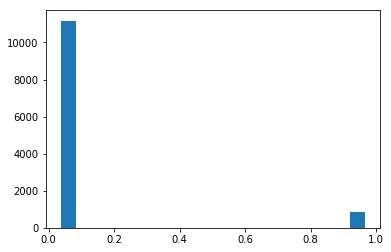

In [27]:
# Distribution of the training marginals
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [28]:
# Learned accuracy parameters, and other statistics about the LFs learned by the generative model
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.961620,0.8442,0.963480,0.813912
1,0.527202,0.6654,0.533883,0.343682


### Iterate on Labeling Functions
Improve the LF set.  First, apply the LFs to the development set:

In [29]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [30]:
# Get the score of the generative model
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.784
Neg. class accuracy: 0.97
Precision            0.639
Recall               0.784
F1                   0.704
----------------------------------------
TP: 76 | FP: 43 | TN: 1375 | FN: 21



In [31]:
# Explore some of the additional functionalities of the lf_stats method for the dev set
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_distant_supervision,0,1.000000,0.141254,0.080528,76,0,21,0,0.783505,0.965525
LF_weak_classifier,1,0.141254,0.141254,0.080528,95,0,0,0,1.000000,0.519736


### Save the training labels

Save the `training_marginals` (**probabilistic training labels**) for later use to train an end extraction model:

In [32]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 12031 marginals
CPU times: user 6.65 s, sys: 52 ms, total: 6.7 s
Wall time: 6.8 s


## Training an End Extraction Model
Use the noisy training labels to train the end extraction model (Bi-LSTM, a state-of-the-art deep neural network). 

In [33]:
# Reload the probabilistic training labels
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

In [34]:
# Reload the candidates
train_cands = session.query(Exercise).filter(Exercise.split == 0).order_by(Exercise.id).all()
dev_cands   = session.query(Exercise).filter(Exercise.split == 1).order_by(Exercise.id).all()
test_cands  = session.query(Exercise).filter(Exercise.split == 2).order_by(Exercise.id).all()

In [35]:
# Load the gold labels for evaluation
from snorkel.annotations import load_gold_labels

L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [36]:
# Setup the discriminative model
'''
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)
'''

"\nfrom snorkel.learning.disc_models.rnn import reRNN\n\ntrain_kwargs = {\n    'lr':         0.01,\n    'dim':        50,\n    'n_epochs':   10,\n    'dropout':    0.25,\n    'print_freq': 1,\n    'max_sentence_length': 100\n}\n\nlstm = reRNN(seed=1701, n_threads=None)\nlstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)\n"

In [39]:
# Stats from the discriminative model
#p, r, f1 = lstm.score(test_cands, L_gold_test)
#print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

In [40]:
# Save predictions of the model to database
#lstm.save_marginals(session, test_cands)